In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
import math
from mplEasyAnimate import animation
from tqdm import tqdm
from IPython.display import HTML

# Molecular Dynamic Simulator Simulator

This program attempts to recreate the diatomic gas animation from the EJSS simulation created by Wolfgang Christian, Francisco Esquembre, and David Schroeder.
This simulation adds the addition of a bond that alters the interaction of particles under the influence of the Lennard-Jones potential.



In [2]:
def easyanimate_gas(N_skip, t_array, x1_array, y1_array, x2_array, y2_array, filename): #N_skip is number of frames to skip
    t_offsets = t_array
    anim = animation(filename)
    i=0
    for offset in tqdm(t_offsets):
        if i % N_skip == 0:
            fig, ax = plt.subplots(1, 1, figsize=(10, 7))
            ax.plot(x1_array[i], y1_array[i],'ko')
            ax.plot(x2_array[i], y2_array[i],'ko')
            ax.set_xlim(0,5)
            ax.set_ylim(0,5)
            anim.add_frame(fig)
            plt.close(fig)
        i=i+1
    anim.close() 

Much like the previous project involving the bouncing ball, the computeAccelerations function is the identical accept for a section of code that has been added to create the diatomic aspect of the program.

In [3]:
def computeAccelerations(N,data,boxWidth,a,g):
    i=0
    j=0
    x=data[:,0]
    y=data[:,1]
    vx=data[:,2]
    vy=data[:,3]
#     print(a)
    ax=a[0,0]
#     print(len(ax))
    ay=a[0,1]
    dx=0
    dy=0
    dx2=0
    dy2=0
    r=0
    rSquared=0
    rSquaredInv=0
    attract=0
    repel=0
    fOverR=0
    fx=0
    fy=0
    wallStiffness = 50
    wallForce = 0
    potentialE = 0
    forceCutoff = 3.0
    forceCutoff2 = forceCutoff*forceCutoff
    pEatCutoff=4*math.pow(forceCutoff,-12)-math.pow(forceCutoff,-6)
    ####check for bounces off walls##############
    for i in range(N):
        if x[i]<0.5:
            ax[i] = wallStiffness*(0.5-x[i])
            wallForce=wallForce+ax[i]
            potentialE=potentialE+0.5*wallStiffness*(0.5-x[i])*(0.5-x[i])
        elif x[i]>(boxWidth-0.5):
            ax[i]=wallStiffness*(boxWidth-0.5-x[i])
            wallForce=wallForce-ax[i]
            potentialE=potentialE+.05*wallStiffness*(boxWidth-0.5-x[i])*(boxWidth-0.5-x[i])
        else:
#             print(ax[i])
            ax[i]=0
        if y[i]<0.5:
            ay[i] = wallStiffness*(0.5-y[i])
            wallForce=wallForce+ay[i]
            potentialE=potentialE+0.5*wallStiffness*(0.5-y[i])*(0.5-y[i])
        elif y[i]>(boxWidth-0.5):
            ay[i]=wallStiffness*(boxWidth-0.5-y[i])
            wallForce=wallForce-ay[i]
            potentialE=potentialE+.05*wallStiffness*(boxWidth-0.5-y[i])*(boxWidth-0.5-y[i])
        else:
            ay[i]=0
            ay[i]=ay[i]-g #adds gravity if any
    pressure=wallForce/(4*boxWidth) #instantaneous pressure
#         print(a)
    ##################################################################
    
    ###compute interaction force (Lennard-Jones potential)#############
    i=0
    j=0
    if ((N<100)or(boxwidth<4*forceCutoff)):
        for i in range(N):
            for j in range(N):
                dx=x[i]-x[j]
                dx2=dx*dx
#                 print(dx2)
                #Make sure that the molecules are close enough to bother
                if dx2<forceCutoff2:
                    dy=y[i]-y[j];
                    dy2=dy*dy
                    if dy2<forceCutoff2:
                        rSquared=dx2+dy2+.0000000001
#                         print(rSquared)
                        if rSquared<forceCutoff2:
                            rSquaredInv=1.0/rSquared
                            attract=rSquaredInv*rSquaredInv*rSquaredInv
                            repel=attract*attract
                            potentialE=potentialE+(4.0*(repel-attract))-pEatCutoff
                            fOverR=24*((2.0*repel)-attract)*rSquaredInv
                            fx=fOverR*dx
                            fy=fOverR*dy
                            #add force onto i's acceleration
                            ax[i]=ax[i]+fx
                            ay[i]=ay[i]+fy
                            #Newton's 3rd law
                            ax[j]=ax[j]-fx
                            ay[j]=ay[j]-fy
                            a=np.array([ax,ay])#place acceleration into an array that can be returned by the function
#             print(a)
    # O(N) cell-based approach for a large system

    else:
        nCells=math.floor(boxWidth/forceCutoff)
        cellWidth=boxWidth/nCells
        listHeader=np.array(nCells*nCells)
        neighborindex=0
        neighborOffset=np.array([[0,0],[1,0],[1,1],[0,1],[-1,1]])
        for i in range(nCells*nCells):
            listHeader[i]=-1 #set all cells to empty
        linkedList=np.array(N)
        for i in range(N):
            xcell=math.floor(x[i]/cellWidth)
            if xcell<0:
                xcell=0
            if xcell>nCells:
                xcell=nCells-1
            ycell=math.floor(y[i]/cellWidth)
            if ycell<0:
                ycell=0
            if ycell>nCells:
                ycell=nCells-1
            #flatten the 2d structure into a 1d array
            cellHeaderIndex=xcell+nCells*ycell
            linkedList[i]=listHeader[cellHeaderIndex]#This atom now points where the header used to
            listHeader[cellHeaderIndex]=i #now the header points to this atom
            xcell=0
            ycell=0
            for xcell in range(nCells):
                for ycell in range(nCells):
                    thiscell=xcell+nCells*ycell #index of this cell in the header list
                    for neighborIndex in range(5):
                        xneighborcell=xcell+neighborOffset[neighborIndex,0]#equivalent of neighborOffset[index].x
                        if ((xneighborcell<0)or(xneighborcell>=nCells)): #some neighbors don't actually exist
                            continue
                        yneighborcell=ycell+neighborOffset[neighborIndex,1]#equivalent of neighborOffset[index].y
                        if (yneighborcell>=nCells):
                            continue
                        neighborcell=xneighborcell+nCells*yneighborcell
                        i=listHeader[thiscell]
                        while i>-1:
                            j=listHeader[neighborcell]
                            if neighborcell==thiscell: #don't count atoms in this cell twice
                                j=linkedList[i]
                            while j>-1:
                                dx=x[i]-x[j]
                                dx2=dx*dx
                                if dx2<forceCutoff2:
                                    dy=y[i]-y[j]
                                    dy2=dy*dy
                                    if dy2<forceCutoff2:
                                        rsquared=dx2+dy2
                                        if rSquared<forceCutoff2:
                                            rSquaredInv=1/rSquared
                                            attract=rSquaredInv*rSquaredInv*rSquaredInv
                                            repel=attract*attract
                                            potentialE=potentialE+(4*(repel-attract))-pEatCutoff
                                            fOverR=24*(2*repel-attract)*rSquaredInv
                                            fx=fOverR*dx
                                            fy=fOverR*dy
                                            ax[i]=ax[i]+fx
                                            ay[i]=ay[i]+fy
                                            #Newton's third law
                                            ax[j]=ax[j]-fx
                                            ay[j]=ay[j]-fy
                                            print('test')
                                            a=np.array([ax,ay])#place acceleration into an array that can be returned by the function
                                j=linkedList[j]
                            i=linkedList[i]
    ######### end of L-J force computation ##########################################
    # if applicable, this is where you would calculate the elastic forces between bonded atoms
    bondstrength = 100
    i=0
    for i in range(bondCount*2):
        i1=bondlist[i]
        i2=bondlist[i+1]
        dx = x[i1]-x[i2]
        dy = y[i1]-y[i2]
        r = math.sqrt(dx*dx+dy*dy)
        roffset = r - 1.122462 #offset by the L-J equilibrium position
        potentialE += 0.5*bondstrength*roffset*roffset
        fx = bondstrength*roffset*dx/r
        fy = bondstrength*roffset*dy/r
        ax[i1] = ax[i1]-fx
        ay[i1] = ay[i1]-fy
        ax[i2] = ax[i2]+fx
        ay[i2] = ay[i2]+fy
    # if applicable, set the accelerations of fixed atoms to 0
    
    # if applicable, set the force needed to drag an atom with the mouse
#     print(a)
    return a   

In [4]:
def doStep(N,data,boxWidth,a,g,dt):
    x=data[:,0]
    y=data[:,1]
    vx=data[:,2]
    vy=data[:,3]
#     print(data[:,2])
#     print('----------------------')
    ax=a[0,0]
    ay=a[0,1]
    halfdt=0.5*dt
    halfdtsquared=halfdt*halfdt
    i=0
    for i in range(N):
        x[i]=x[i]+vx[i]*dt+ax[i]*halfdtsquared
        y[i]=y[i]+vy[i]*dt+ay[i]*halfdtsquared
        vx[i]=vx[i]+ax[i]*halfdt
        vy[i]=vy[i]+ax[i]*halfdt
    computeAccelerations(N,data,boxWidth,a,g)
    for i in range(N):
        vx[i]=vx[i]+ax[i]*halfdt
        vy[i]=vy[i]+ay[i]*halfdt
        x[i]=x[i]+vx[i]*dt
        y[i]=y[i]+vy[i]*dt
        pos=np.array([x,y])# sets velocities into an array that can be returned by the function
    # If applicable, set the velocity for fixed molecules to 0
    
    # If applicable, set random velocities to fixed temperature atoms
#     print(x)
#     print(y)
#     plt.figure()
#     plt.plot(x,y,'o')    
    return pos

In [5]:
def simulate(N,data,steps,boxWidth,a,g,dt):
    file='gas-lf-pbc.mp4'
    time = np.zeros(steps)
    x=data[:,0]
    y=data[:,1]
    x1 = np.zeros(steps)
    x2 = np.zeros(steps)
    y1 = np.zeros(steps)
    y2 = np.zeros(steps)
    vx=np.zeros(N)
    vy=np.zeros(N)
    plt.figure()
    plt.plot(x,y,'o')
#     v=np.array([[vx,vy]])
    posarray = np.zeros((2,2),)
#     print(posarray)
    curstep=0
    while curstep<steps:
        pos = doStep(N,data,boxWidth,a,g,dt)
#         print(pos)
#         print(pos[0,0])
#         print(pos[1,0])
        x1[curstep] = pos[0,0]
        x2[curstep] = pos[1,0]
        y1[curstep] = pos[0,1]
        y2[curstep] = pos[1,1]
#         print(x1)
#         print(x2)
#         print(y1)
#         print(y2)
        time[curstep] = time[curstep]+dt
        curstep=curstep+1

#     print(pos[0,0])
    easyanimate_gas(5,time,x1,y1,x2,y2,file)
#     print(curstep)
        
#     return posarray
    

This first example is a test to see if I could get two particles that aren't a diatomic molecule to interact the same way that the simulation by Schroder does.

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:13<00:00, 38.40it/s]


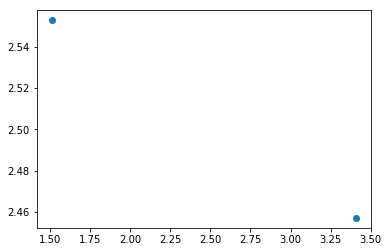

In [6]:
#"Two Atoms"
N=2 #Number of particles
boxWidth=5
g=0
#changeN(N)#may not be necessary
dt=0.020
steps=500 #number of steps
ax=np.zeros(N)
ay=np.zeros(N)
a=np.array([[ax,ay]])
#print(len(a[0,1]))
# print(a[0,0])
# print(ax)
spd=1 #how fast you step through the program
#The three variables below are not applicable to this particular model.
fixedCount=0 #number of fixed molecules i.e. they don't move at all during the simulation
bondCount=0 #number of molecules connected elastically by a bond
fixedTCount=0 #number of molecules with fixed temperature

#The given preset positions and velocities were given in the format [x-position,y-position,x-velocity,y-velocity]
data=np.array([[1.511083,2.552912, 0, 0],[3.408917, 2.457088, 0, 0]])
# x = data[:,0]
# y = data[:,1]
# vx = data[:,2]
# vy = (data[:,3])
computeAccelerations(N,data,boxWidth,a,g)
# plt.plot(data[:,0],data[:,1], 'o')
# print(pos)
simulate(N,data,steps,boxWidth,a,g,dt)
#plot_frame(0,pos,v)


In [7]:
def playVideo(path):
    return HTML("""
                <video width="320" height="240" controls>
                  <source src="{}" type="video/mp4">
                </video>
                """.format(path))

In [8]:
file='gas-lf-pbc.mp4'
playVideo(file)

As the current state shows, there is a hint of how the particles should behave but it quickly breaks down.  The only correct thing that happens is that as the particles begin to pass through the 'wall' that set up, their velocities start to increase in magnitude as they are flung back toward the center.  Unfortunately, all this does is create a slippery slope where the particles get launched with increasing force past each other rather than being stuck in the potential well like they do in schroder's simulation.

In [ ]:
#"diatomic gas"
N=4 #Number of particles
boxWidth=5
g=0
#changeN(N)#may not be necessary
dt=0.020
steps=500 #number of steps
ax=np.zeros(N)
ay=np.zeros(N)
a=np.array([[ax,ay]])
#print(len(a[0,1]))
# print(a[0,0])
# print(ax)
spd=1 #how fast you step through the program
#The three variables below are not applicable to this particular model.
fixedCount=0 #number of fixed molecules i.e. they don't move at all during the simulation
bondCount=2 #number of molecules connected elastically by a bond
fixedTCount=0 #number of molecules with fixed temperature

#The given preset positions and velocities were given in the format [x-position,y-position,x-velocity,y-velocity]
data=np.array([[1.511083,2.552912, 0, 0],[3.408917, 2.457088, 0, 0]])
# x = data[:,0]
# y = data[:,1]
# vx = data[:,2]
# vy = (data[:,3])
computeAccelerations(N,data,boxWidth,a,g)
# plt.plot(data[:,0],data[:,1], 'o')
# print(pos)
simulate(N,data,steps,boxWidth,a,g,dt)
#plot_frame(0,pos,v)


As much as I would like to work on the diatomic gas, until I can get to normal particles behaving correctly I don't think it is wise to try and add in additional complications to the model.  Once I get the first step working right I will resume work on the diatomic gas model.